# nerve_mask & hovernet_inference

- 패치(또는 tile)수준에서 **nerve_mask**와 **hovernet_inference**에서 tumor(빨간색)인 것만 추출한 **mask**를 이용하여 inference를 해보겠습니다.

#### json 파일 만들기 및 tumor segmentation 확인

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import math
import openslide as ops
import os
import json

from hover.postproc import process_utils as proc_utils
from hover.misc.wsi_handler import get_wsi_handler
from hover.misc.utils import visualize_instances
from run import InferTile, InferWSI 

In [2]:
args = {}

args['--gpu'] = '0,1'                  
args['--batch_size'] = 30            
args['--inf_tile_shape'] = 512     
args['--proc_tile_shape'] = 512     
args['--return_probs'] = True
args['--model'] = 'weight/pannuke.npz'
args['--input_dir'] = 'tile/tile_input/test_col_p2_tile'
args['--output_dir'] = 'tile/tile_output/test_p2' 

In [3]:
infer_pannuke = InferTile()
infer_pannuke._parse_args(args)
infer_pannuke.load_model()
infer_pannuke.process_all_files()

Loading Model...
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Processing Images: 100%|##########################| 1/1 [00:09<00:00,  9.24s/it]


In [4]:
tile_path = 'tile/tile_input/test_col_p2_tile/2.png'

tile = cv2.imread(tile_path)
tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

In [5]:
n_mask_path = 'tile/tile_input/test_col_p2_mask/2_p2.png'

n_mask = cv2.imread(n_mask_path, 0)

### patch(tile), nerve mask, hovernet_inference

tile/tile_output/test_p2/2/overlay.png


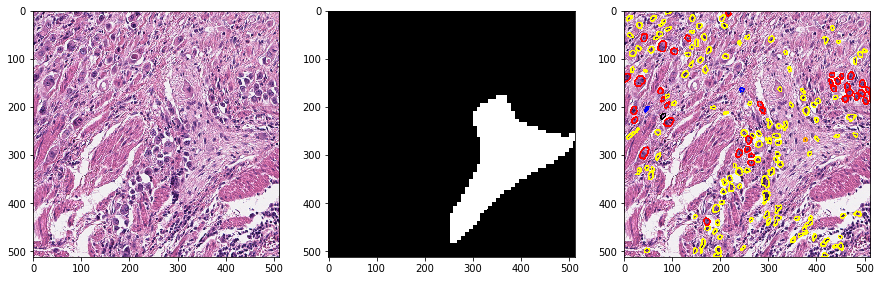

In [6]:
path_pannuke = args['--output_dir']  + '/2/overlay.png'
print(path_pannuke)
overlay_pannuke = cv2.imread(path_pannuke)
overlay_pannuke = cv2.cvtColor(overlay_pannuke, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(tile)
plt.subplot(1, 3, 2)
plt.imshow(n_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(overlay_pannuke)

#### hovernet 마스크 만들기

In [7]:
import json

In [8]:
json_path = 'tile/tile_output/test_p2/2' + '/nuclei_dict.json'
'/'.join(json_path.split('/')[:-1]) + '/overlay.png'

'tile/tile_output/test_p2/2/overlay.png'

In [9]:
img = cv2.imread('/'.join(json_path.split('/')[:-1]) + '/overlay.png')
mask_h = img.shape[0]
mask_w = img.shape[1]
mask = np.zeros((mask_h, mask_w))

with open(json_path) as json_file:
    data = json.load(json_file)
    for inst in data:
        inst_info = data[inst]
        inst_contour = inst_info['contour']
        inst_type = inst_info['type']
#         print(inst_)
        if inst_type == 1:
            pts = [np.array(inst_contour, dtype=np.int32)]
            if len(inst_contour)!=4:
                mask = cv2.fillPoly(mask,pts,1)
            elif len(inst_contour)==4:
                mask = cv2.fillPoly(mask,pst,1)
            else:
                pass            
    cv2.imwrite('tile/tile_output/test_p2/2/mask.png', mask)
    
mask_path= 'tile/tile_output/test_p2/2/mask.png'
mask = cv2.imread(mask_path, 0)

### patch(tile), nerve mask, hovernet_inference mask(tumor mask)

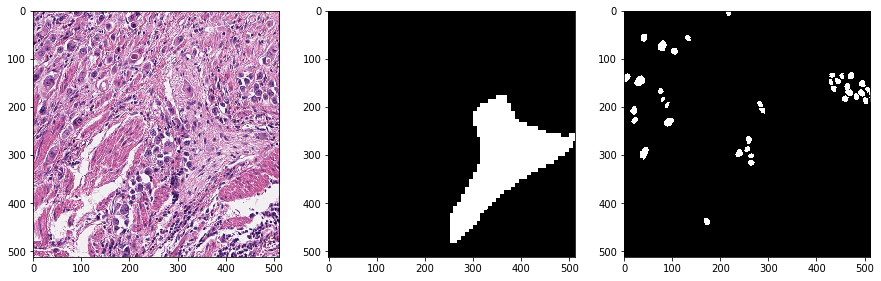

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(tile)
plt.subplot(1, 3, 2)
plt.imshow(n_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')

### patch, contours, dilate

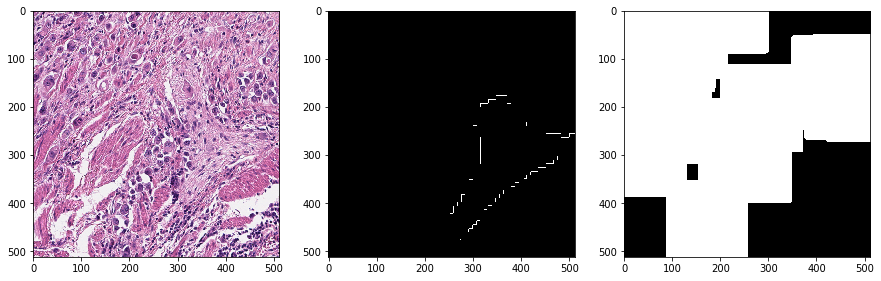

In [11]:
findcontours = cv2.findContours(n_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
drawcontours = cv2.drawContours(np.zeros((mask_h, mask_w)), findcontours, -1, 255, 1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13,13))
dilution_mask = cv2.dilate(mask, kernel, iterations = 13)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(tile)
plt.subplot(1, 3, 2)
plt.imshow(drawcontours, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(dilution_mask, cmap='gray')

> `nerve mask의 외곽선`과 `dilate한 mumor mask`의 겹치는 부분만 추출하도록 해보겠습니다.

### patch(tile), result

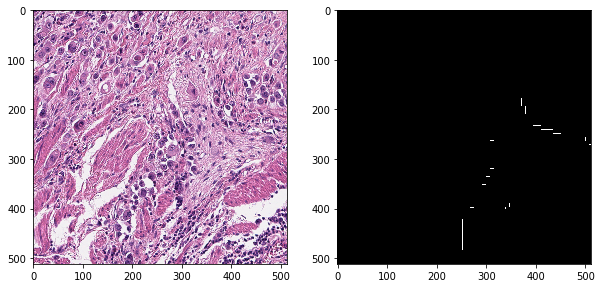

In [13]:
new_mask2=np.logical_and(drawcontours, dilution_mask)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(tile)
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(new_mask2), cmap='gray')